In [2]:
import pandas as pd
import numpy as np
import math
import scipy as sp
import scipy.stats as si
import statsmodels.api as sm
import pandas_datareader
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from sklearn import datasets , linear_model
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sy
from sympy.stats import Normal, cdf
import urllib.request
import zipfile

# part A---------------------------------------------------------------------------------part A

In [3]:
#Import data
start_date = '1995-01-01'
end_date = '2020-12-31'
lst_tickers = ['SPY', '^VIX']
def collect_data(lst_tickers, start_date, end_date):
    df1 = []
    df2 = []
    
    df1 = data.get_data_yahoo(lst_tickers[0], start = start_date, end = end_date)
    df1 = df1[["Adj Close"]]
    df1 = df1.dropna()
    index = df1.index
    df1.rename(columns = {"Adj Close" : lst_tickers[0]}, inplace=True)
    
    df2 = data.get_data_yahoo(lst_tickers[1], start = start_date, end = end_date)
    df2 = df2[["Adj Close"]]
    df2 = df2.dropna()
    index = df2.index
    df2.rename(columns = {"Adj Close" : lst_tickers[1]}, inplace=True)
    df1 = pd.concat([df1, df2], axis =1)
    return df1

<AxesSubplot:xlabel='Date'>

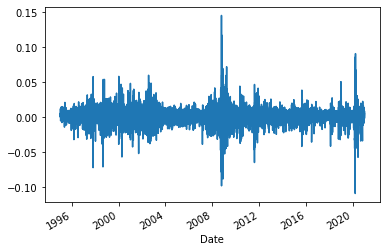

In [5]:
master_df = collect_data(lst_tickers, start_date, end_date)
master_df = master_df.dropna()
master_df['SPY'] = master_df['SPY'].pct_change()
master_df['^VIX'] = master_df['^VIX'].diff()
#master_df['SPY'].plot()
#master_df['^VIX'].plot()

Part B------------------------------------------------------------------------Part B------------------------------------------------------------------------Part B

In [4]:
# Calcualte auto correlations(top function uses shifts, second function uses an ARMA+ stationarity test appraoch)
def ARMA_regression(df,lst):
    df = df.dropna()
    df.index = pd.DatetimeIndex(df.index).to_period('D')
    for i in range(len(lst)):
        #for j in range(4):             #  additional arguments to mess with  ,trend=None,enforce_stationarity=True,dates=None,validate_specification=True
            model = ARIMA(df[lst[i]], order=(1,0,0),trend=None,enforce_stationarity=True)
            results = model.fit()
            print(lst[i])
            print(results.summary())#.as_latex())
            test_stats = sm.stats.acorr_ljungbox(results.resid,lags=[5],return_df=True,boxpierce=True,auto_lag=False)
            print(test_stats)
    return results

In [5]:
spy = ARMA_regression(master_df,lst_tickers)
spy

SPY
                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                 6546
Model:                 ARIMA(1, 0, 0)   Log Likelihood               19573.867
Date:                Thu, 04 Nov 2021   AIC                         -39141.733
Time:                        19:47:53   BIC                         -39121.373
Sample:                    01-04-1995   HQIC                        -39134.694
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      3.314      0.001       0.000       0.001
ar.L1         -0.0914      0.006    -14.266      0.000      -0.104      -0.079
sigma2         0.0001   1.03e-06    144.051     

Part C------------------------------------------------------------------------Part C------------------------------------------------------------------------Part C

           SPY      ^VIX
SPY   1.000000 -0.800412
^VIX -0.800412  1.000000


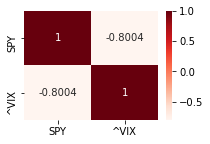

          SPY     ^VIX
SPY   1.00000 -0.80128
^VIX -0.80128  1.00000


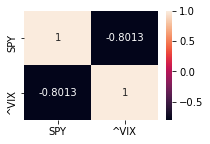

In [6]:
# Calculate correlations for the whole interval
correlation_df = master_df.corr()
print(correlation_df)

plt.figure(figsize = (3,2))
sns.heatmap(master_df.corr(), cmap="Reds", annot=True,fmt='.4g')
plt.show()

# Calutate at a monthly interval
monthly = master_df.asfreq('M').ffill()
monthly = monthly.dropna()
print(monthly.corr())
plt.figure(figsize = (3,2))
sns.heatmap(monthly.corr(), cmap="rocket", annot=True,fmt='.4g')
plt.show()

Part D------------------------------------------------------------------------Part D------------------------------------------------------------------------Part D

In [7]:
# Rolling correlation 90-day for SPY & VIX 
def rolling_ninty_day(df):
    spy_rolling_corr = df['SPY'].rolling(90).corr(df['^VIX'])
    spy_rolling_corr = spy_rolling_corr.dropna()
    index_rolling = spy_rolling_corr.index
    df_90 = pd.DataFrame(spy_rolling_corr, index_rolling)
    return df_90

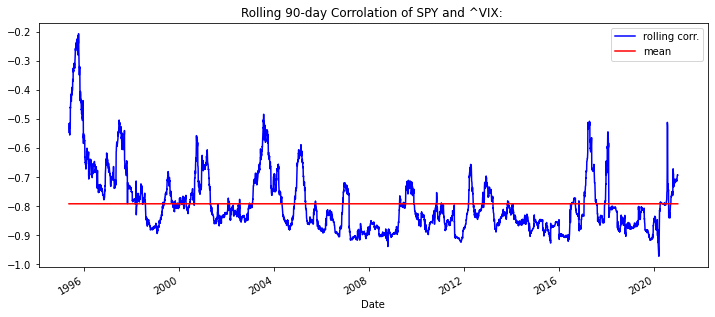

In [8]:
rolling_df = rolling_ninty_day(master_df)
rolling_df.rename({0: '90-day corr'}, axis=1, inplace=True)
rolling_df['mean'] = np.nan
rolling_df['mean'] = rolling_df['90-day corr'].mean()
#print(rolling_df)
fig = plt.figure(figsize=(12,5))
ax = plt.gca()
plt.title('Rolling 90-day Corrolation of SPY and ^VIX: ')
rolling_df['90-day corr'].plot(kind='line',color='blue',label='rolling corr.',ax=ax)
rolling_df['mean'].plot(kind='line',color='red',ax=ax)
plt.legend()
plt.show()

Part E------------------------------------------------------------------------Part E------------------------------------------------------------------------Part E

In [9]:
#calculate realized volatility - rolling 90-day 
def rolling_ninty_day_var(df):
    spy_rolling_var = df['SPY'].rolling(90).std()
    spy_rolling_var = spy_rolling_var.dropna()
    index_rolling = spy_rolling_var.index
    df_90 = pd.DataFrame(spy_rolling_var, index_rolling)
    
    return df_90

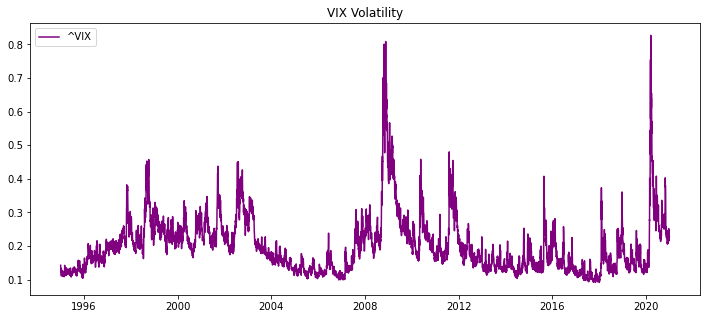

In [10]:
# the 90-day measure is fine, but a 30-day measure may make more sense given how the vix is calculated
rolling_var = rolling_ninty_day_var(master_df)
fig = plt.figure(figsize=(12,5))
plt.title('VIX Volatility')
#plt.plot(rolling_var*(252**0.5))
levels_df = collect_data(lst_tickers, start_date, end_date)
levels_df = levels_df.dropna()
plt.plot(levels_df['^VIX']/100,color='purple', label="^VIX")
plt.legend()

In [29]:
def volatility(df):
    df['SPY'] = df['SPY'].pct_change()
    df['SPY'] = df['SPY'].rolling(10).std()
    df['SPY'] = df['SPY']*(252**0.5)
    df['^VIX'] = df['^VIX']/100
    #print(df)
    df['IV premium'] = np.nan
    for index, row in df.iterrows():
        row['IV premium'] = row['^VIX'] - row['SPY']
    #print(df)
    #df['^VIX'].plot()
    #df['SPY'].plot()
    return df

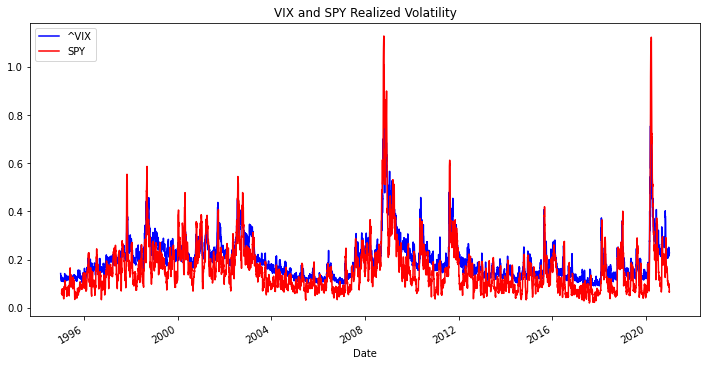

In [30]:
levels_df = collect_data(lst_tickers, start_date, end_date)
levels_df = levels_df.dropna()
volatility_df = volatility(levels_df)
fig = plt.figure(figsize=(12,6))
plt.title('VIX and SPY Realized Volatility')
volatility_df['^VIX'].plot(kind="line",color='blue', label="^VIX")
volatility_df['SPY'].plot(kind="line",color='red', label = "SPY")
plt.legend()

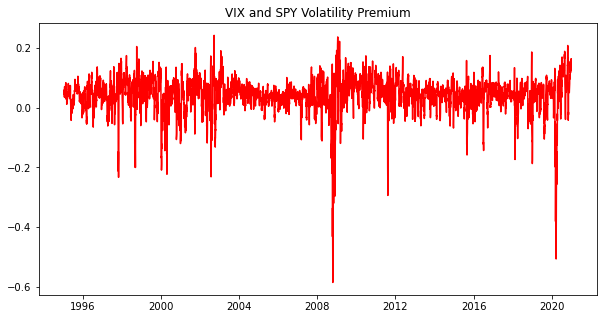

In [31]:
# IV-realized volatility plot
fig = plt.figure(figsize=(10,5))
plt.title('VIX and SPY Volatility Premium')
#plt.plot(-levels_df['SPY']+levels_df['^VIX']) #it is largely positive but not consistent
plt.plot(levels_df['IV premium'],color='red', label="^VIX")

Part F------------------------------------------------------------------------Part F------------------------------------------------------------------------Part F

In [32]:
def euro_put(s_0, K, T, r, sigma):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(s_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(s_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - s_0 * si.norm.cdf(-d1, 0.0, 1.0))
    
    return put

In [33]:
BS_put = euro_put(90.443787, 90.443787, 1/12, 0.0, 19.350000/100)
print(BS_put)

2.015221054675834


In [34]:
def euro_call(s_0, K, T, r, sigma):
    
    #s_0: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(s_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(s_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (s_0 * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [35]:
BS_call = euro_call(90.443787, 90.443787, 1/12, 0.0, 19.350000/100)
print(BS_call)
print(BS_call + BS_put)

2.015221054675834
4.030442109351668


In [36]:
def option_portfolio(LevelDF, pctChngDF):
    portfolio = LevelDF
    portfolio['Straddle'] = np.nan

    #s_0: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    for index, row in LevelDF.iterrows():
        BS_call = euro_call(row['SPY'], row['SPY'], 1/12, 0.0, row['^VIX']/100)
        BS_put = euro_put(row['SPY'], row['SPY'], 1/12, 0.0, row['^VIX']/100)
        row['Straddle'] = BS_call + BS_put
    
    
    return portfolio

In [37]:
Levels_df = collect_data(lst_tickers, start_date, end_date)
portfolioDF = option_portfolio(Levels_df, master_df)
portfolioDF=portfolioDF.dropna()
#print(portfolioDF)

In [38]:
def rolling_sum(df):
    monthly_port_value = df.rolling(90).mean()
    #plt.plot(monthly_port_value['Straddle'],color='red',label="Straddle value")
    #plt.legend()
    return monthly_port_value

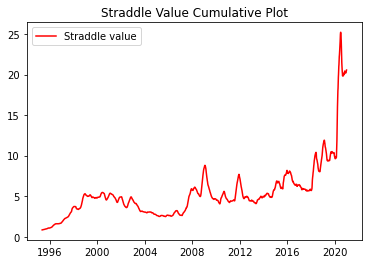

In [39]:
portSum = rolling_sum(portfolioDF)
plt.title('Straddle Value Cumulative Plot')
plt.plot(portSum['Straddle'],color='red',label="Straddle value")
plt.legend()

Part G------------------------------------------------------------------------Part G------------------------------------------------------------------------Part G

In [40]:
# calculate payoffs and plot it
def straddlePayoff(df):
    df['K'] = np.nan
    for index, row in df.iterrows():
        row['K'] = row['SPY']
    #fig = plt.figure(figsize=(15,8))
    #monthly = df['K'].asfreq('M').ffill()
    monthly = df['K'].asfreq('M').bfill()
    #plt.plot(monthly)
    #plt.plot(df['K'])
    df2 = monthly.asfreq('D').bfill()
    #df2 = monthly.asfreq('D').ffill()
    #plt.plot(df2)
    df.rename({'K': 'strike'}, axis=1, inplace=True)
    result = pd.concat([df, df2], axis=1).reindex(df.index)
    #print(result)
    df3 = result.drop(result.columns[[3]], axis = 1)
    
    df3['Straddle Profit'] = np.nan
    for index, roww in df3.iterrows():
        call_payoff = max(roww['SPY']-roww['K'],0) #- euro_call(roww['SPY'], roww['SPY'], 1/12, 0.0, roww['^VIX']/100)
        put_payoff = max(roww['K']-roww['SPY'],0) #- euro_put(roww['SPY'], roww['SPY'], 1/12, 0.0, roww['^VIX']/100)
        premium = euro_call(roww['SPY'], roww['SPY'], 1/12, 0.0, roww['^VIX']/100) + euro_put(roww['SPY'], roww['SPY'], 1/12, 0.0, roww['^VIX']/100)
        roww['Straddle Profit'] = max(call_payoff,put_payoff) - premium
    return df3#result

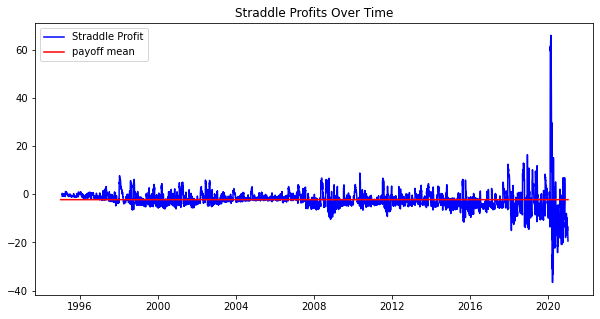

In [41]:
straddles = straddlePayoff(portfolioDF)
fig = plt.figure(figsize=(10,5))
plt.title('Straddle Profits Over Time')
plt.plot(straddles['Straddle Profit'],color='blue',label='Straddle Profit')
straddles['payoff mean']=straddles['Straddle Profit'].mean()
plt.plot(straddles['payoff mean'],color='red',label='payoff mean')
plt.legend()
#print(straddles.head())

Part H------------------------------------------------------------------------Part H------------------------------------------------------------------------Part H

Text(0.5, 1.0, 'Profit and Premium Scatter Plot')

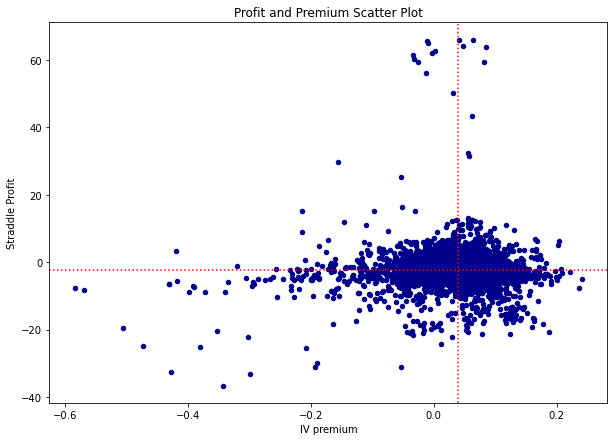

In [42]:
scatterDF = pd.concat([straddles, levels_df['IV premium']], axis=1).reindex(straddles.index)
scatterDF.plot.scatter(x='IV premium',y='Straddle Profit',c='DarkBlue',figsize=(10,7))
plt.axhline(y=scatterDF['Straddle Profit'].mean(),color='red',linestyle='dotted')
plt.axvline(x=scatterDF['IV premium'].mean(),color='red',linestyle='dotted')
plt.title('Profit and Premium Scatter Plot')
#sns.lmplot(x='IV premium',y='Straddle Profit',data=scatterDF,fit_reg=True)